In [26]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
# Load datasets
criminal_Expanded=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Criminal+expanded.csv')
criminal_behavior_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/criminal_profiling_data_fixed_preprocessed.csv')
psychological_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/psychological_data_preprocessed.csv')


In [28]:
print("Criminal Expanded Data:")
criminal_Expanded.head()

Criminal Expanded Data:


,ssl_score,age_curr,idoc_res_zip_code,sex_code_cd,race_code_cd,majority_dist,latest_dist_res
0,NaN,20-30,NaN,M,WWH,De-identified,31.0
1,310.0,20-30,De-identified,M,API,De-identified,31.0
2,362.0,less than 20,NaN,F,NaN,De-identified,31.0
3,380.0,20-30,De-identified,M,WHI,De-identified,NaN
4,365.0,less than 20,De-identified,M,BLK,6,31.0


In [30]:
print("Criminal Expanded Data:")
missing_values2=criminal_Expanded.isnull().sum()
missing_values2

Criminal Expanded Data:


,0
ssl_score,30000
age_curr,30000
idoc_res_zip_code,30000
sex_code_cd,30000
race_code_cd,30000
majority_dist,30000
latest_dist_res,30000


In [31]:
criminal_Expanded=criminal_Expanded.drop(
    ["idoc_res_zip_code","majority_dist","latest_dist_res"],
    axis=1,
    errors='ignore'
    )
criminal_Expanded.head()

,ssl_score,age_curr,sex_code_cd,race_code_cd
0,NaN,20-30,M,WWH
1,310.0,20-30,M,API
2,362.0,less than 20,F,NaN
3,380.0,20-30,M,WHI
4,365.0,less than 20,M,BLK


In [32]:
age_mapping = {
    'less than 20': 15,
    '20-30': 25,
    '30-40': 35,
    '40+': 50
}

# Apply the mapping to the age_curr column
criminal_Expanded['age_curr'] = criminal_Expanded['age_curr'].replace(age_mapping)

# Convert the column to numeric
criminal_Expanded['age_curr'] = pd.to_numeric(criminal_Expanded['age_curr'], errors='coerce')

criminal_Expanded['Age_Group'] = pd.cut(
    criminal_Expanded['age_curr'],
    bins=[0, 20, 40, 100],
    labels=['<20', '20-40', '40+']
)
criminal_Expanded=criminal_Expanded.drop(["age_curr"],
                                         axis=1,
                                         errors='ignore'
                                         )

criminal_Expanded.head()

,ssl_score,sex_code_cd,race_code_cd,Age_Group
0,NaN,M,WWH,20-40
1,310.0,M,API,20-40
2,362.0,F,NaN,<20
3,380.0,M,WHI,20-40
4,365.0,M,BLK,<20


In [33]:
criminal_Expanded["ssl_score"]=criminal_Expanded["ssl_score"].fillna(criminal_Expanded["ssl_score"].median())
criminal_Expanded['Age_Group'] = criminal_Expanded['Age_Group'].fillna(criminal_Expanded['Age_Group'].mode()[0])
criminal_Expanded['sex_code_cd'] = criminal_Expanded['sex_code_cd'].fillna(criminal_Expanded['sex_code_cd'].mode()[0])
criminal_Expanded['race_code_cd'] = criminal_Expanded['race_code_cd'].fillna(criminal_Expanded['race_code_cd'].mode()[0])
criminal_Expanded.head()


,ssl_score,sex_code_cd,race_code_cd,Age_Group
0,362.0,M,WWH,20-40
1,310.0,M,API,20-40
2,362.0,F,BLK,<20
3,380.0,M,WHI,20-40
4,365.0,M,BLK,<20


In [34]:
from sklearn.preprocessing import LabelEncoder

columns=['sex_code_cd', 'race_code_cd', 'Age_Group']
encoder = LabelEncoder()

# Apply Label Encoding to each column
for col in columns:
    criminal_Expanded[col] = encoder.fit_transform(criminal_Expanded[col])
criminal_Expanded.head()


,ssl_score,sex_code_cd,race_code_cd,Age_Group
0,362.0,1,5,0
1,310.0,1,0,0
2,362.0,0,1,1
3,380.0,1,4,0
4,365.0,1,1,1


In [35]:
# Display dataset summaries
print("Criminal Behavior Data:")
criminal_behavior_data.head()

Criminal Behavior Data:


,Name,Date of Birth,Gender,Nationality,Criminal Record,Residence,Crime Type,Crime Date,Crime Time,Latitude,Longitude,Evidence Collected,Victim Info
0,Name_0,1993-03-31,Male,Australian,Cybercrime,"441 Pine St., Springfield",Fraud,2022-06-22,02:11:30,-55.421982,-123.431543,Fingerprint,"Female, Age 28"
1,Name_1,1952-05-10,Female,American,Burglary,"992 Pine St., Sydney",Burglary,2017-01-09,07:18:39,-14.411651,-111.418383,DNA Sample,"Female, Age 28"
2,Name_2,1964-10-04,Male,Canadian,Fraud,"902 Pine St., Sydney",Assault,2015-06-17,12:58:13,-67.287944,-67.619901,Surveillance Footage,"Male, Age 35"
3,Name_3,1982-10-04,Male,British,Assault,"209 Oak St., Springfield",Assault,2021-01-28,22:59:03,-67.484036,-91.657427,DNA Sample,"Male, Age 50"
4,Name_0,1980-11-23,Other,British,Assault,"617 Oak St., New York",Cybercrime,2011-12-28,13:29:30,77.243051,99.100840,DNA Sample,"Female, Age 28"


In [36]:
print("Criminal Behavior Data:")
missing_values=criminal_behavior_data.isnull().sum()
missing_values

Criminal Behavior Data:


,0
Name,0
Date of Birth,0
Gender,0
Nationality,0
Criminal Record,0
Residence,0
Crime Type,0
Crime Date,0
Crime Time,0
Latitude,0


In [37]:
criminal_behavior_data = criminal_behavior_data.drop(
    ["Name","Crime Date","Residence", "Victim Info","Evidence Collected","Latitude","Longitude","Nationality"],
    axis=1,
    errors='ignore'
)
criminal_behavior_data.head()

,Date of Birth,Gender,Criminal Record,Crime Type,Crime Time
0,1993-03-31,Male,Cybercrime,Fraud,02:11:30
1,1952-05-10,Female,Burglary,Burglary,07:18:39
2,1964-10-04,Male,Fraud,Assault,12:58:13
3,1982-10-04,Male,Assault,Assault,22:59:03
4,1980-11-23,Other,Assault,Cybercrime,13:29:30


In [38]:
from datetime import datetime
criminal_behavior_data['Age'] = datetime.now().year - pd.to_datetime(criminal_behavior_data['Date of Birth']).dt.year
criminal_behavior_data.drop(columns=['Date of Birth'], inplace=True)

def categorize_time(time):
    hour = pd.to_datetime(time).hour
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

criminal_behavior_data['CrimePeriod'] = criminal_behavior_data['Crime Time'].apply(categorize_time)
criminal_behavior_data.drop(columns=['Crime Time'], inplace=True)
criminal_behavior_data.head()

,Gender,Criminal Record,Crime Type,Age,CrimePeriod
0,Male,Cybercrime,Fraud,32,Night
1,Female,Burglary,Burglary,73,Morning
2,Male,Fraud,Assault,61,Afternoon
3,Male,Assault,Assault,43,Evening
4,Other,Assault,Cybercrime,45,Afternoon


In [39]:
criminal_behavior_data['Age'] = criminal_behavior_data['Age'].fillna(criminal_behavior_data['Age'].median())
categorical_cols = ['Gender', 'Criminal Record', 'Crime Type', 'CrimePeriod']
for col in categorical_cols:
    criminal_behavior_data[col] = criminal_behavior_data[col].fillna(criminal_behavior_data[col].mode()[0])
criminal_behavior_data.head()

,Gender,Criminal Record,Crime Type,Age,CrimePeriod
0,Male,Cybercrime,Fraud,32,Night
1,Female,Burglary,Burglary,73,Morning
2,Male,Fraud,Assault,61,Afternoon
3,Male,Assault,Assault,43,Evening
4,Other,Assault,Cybercrime,45,Afternoon


In [40]:
categorical_cols=["Gender","Criminal Record","Crime Type","CrimePeriod"]
encoder = LabelEncoder()

# Apply Label Encoding to each column
for col in categorical_cols:
    criminal_behavior_data[col] = encoder.fit_transform(criminal_behavior_data[col])

criminal_behavior_data.head()

,Gender,Criminal Record,Crime Type,Age,CrimePeriod
0,1,2,3,32,3
1,0,1,1,73,2
2,1,3,0,61,0
3,1,0,0,43,1
4,2,0,2,45,0


In [41]:
print("Psychological Data:")
psychological_data.head()

Psychological Data:


,Personality Traits,Mental Health Status,Cognitive Function,Substance Abuse History,Anger Management Issues,Past Trauma,Risk of Recidivism,Stress Level
0,Ambivert,Depression,Low,Both,Yes,Domestic Violence,Medium,Moderate
1,Introvert,Stable,Average,Alcohol,No,Domestic Violence,Low,High
2,Ambivert,Depression,Average,Alcohol,Yes,Domestic Violence,Medium,High
3,Ambivert,Anxiety,High,Alcohol,No,Domestic Violence,Low,Moderate
4,Introvert,PTSD,High,Alcohol,No,Childhood Abuse,High,High


In [42]:
print("Psychological Data:")
missing_values1=psychological_data.isnull().sum()
missing_values1

Psychological Data:


,0
Personality Traits,0
Mental Health Status,0
Cognitive Function,0
Substance Abuse History,0
Anger Management Issues,0
Past Trauma,0
Risk of Recidivism,0
Stress Level,0


In [43]:
# Fill missing values in categorical columns
categorical_cols = ['Risk of Recidivism', 'Stress Level', 'Personality Traits', 'Mental Health Status',
                    'Cognitive Function', 'Substance Abuse History', 'Anger Management Issues', 'Past Trauma']
for col in categorical_cols:
    psychological_data[col] = psychological_data[col].fillna(psychological_data[col].mode()[0])
psychological_data

,Personality Traits,Mental Health Status,Cognitive Function,Substance Abuse History,Anger Management Issues,Past Trauma,Risk of Recidivism,Stress Level
0,Ambivert,Depression,Low,Both,Yes,Domestic Violence,Medium,Moderate
1,Introvert,Stable,Average,Alcohol,No,Domestic Violence,Low,High
2,Ambivert,Depression,Average,Alcohol,Yes,Domestic Violence,Medium,High
3,Ambivert,Anxiety,High,Alcohol,No,Domestic Violence,Low,Moderate
4,Introvert,PTSD,High,Alcohol,No,Childhood Abuse,High,High
...,...,...,...,...,...,...,...,...
299995,Introvert,Stable,Average,Alcohol,Yes,Domestic Violence,High,High
299996,Extrovert,PTSD,High,Alcohol,No,Domestic Violence,High,Moderate
299997,Extrovert,Depression,Average,Alcohol,Yes,Domestic Violence,Medium,Moderate
299998,Extrovert,Stable,Average,Alcohol,Yes,Domestic Violence,Low,Moderate


In [44]:
from sklearn.preprocessing import LabelEncoder

nominal_cols = ['Personality Traits', 'Mental Health Status', 'Substance Abuse History', 'Anger Management Issues','Cognitive Function',
                'Risk of Recidivism', 'Stress Level', 'Past Trauma']

encoder = LabelEncoder()
for col in nominal_cols:
    psychological_data[col] = encoder.fit_transform(psychological_data[col])
psychological_data.head()



,Personality Traits,Mental Health Status,Cognitive Function,Substance Abuse History,Anger Management Issues,Past Trauma,Risk of Recidivism,Stress Level
0,0,2,2,1,1,1,2,2
1,2,4,0,0,0,1,1,0
2,0,2,0,0,1,1,2,0
3,0,0,1,0,0,1,1,2
4,2,3,1,0,0,0,0,0


In [45]:
combined_data = pd.concat([criminal_behavior_data, criminal_Expanded, psychological_data], axis=1)
combined_data.head()

,Gender,Criminal Record,Crime Type,Age,CrimePeriod,ssl_score,sex_code_cd,race_code_cd,Age_Group,Personality Traits,Mental Health Status,Cognitive Function,Substance Abuse History,Anger Management Issues,Past Trauma,Risk of Recidivism,Stress Level
0,1.0,2.0,3.0,32.0,3.0,362.0,1,5,0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0
1,0.0,1.0,1.0,73.0,2.0,310.0,1,0,0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,3.0,0.0,61.0,0.0,362.0,0,1,1,0.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0
3,1.0,0.0,0.0,43.0,1.0,380.0,1,4,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
4,2.0,0.0,2.0,45.0,0.0,365.0,1,1,1,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0


In [46]:
combined_data['reoffend'] = combined_data.apply(
    lambda row: 1 if (
        row['Risk of Recidivism'] > 1 or
        row['Anger Management Issues'] == 1 or
        row['Stress Level'] > 1 or
        row['ssl_score'] > 300
    ) else 0, axis=1
)
combined_data['reoffend'].value_counts()


,count
reoffend,
1,294695
0,6305


In [47]:
from imblearn.over_sampling import SMOTE

X=combined_data.drop("reoffend",axis=1)
y=combined_data["reoffend"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.dtypes

,0
Gender,float64
Criminal Record,float64
Crime Type,float64
Age,float64
CrimePeriod,float64
ssl_score,float64
sex_code_cd,int64
race_code_cd,int64
Age_Group,int64
Personality Traits,float64


In [48]:
X_train.isnull().sum()

,0
Gender,699
Criminal Record,699
Crime Type,699
Age,699
CrimePeriod,699
ssl_score,0
sex_code_cd,0
race_code_cd,0
Age_Group,0
Personality Traits,699


In [49]:
# Handle missing values in X_train
X_train = X_train.fillna(X_train.mode().iloc[0])
X_train = X_train.fillna(X_train.median())

# Handle missing values in X_test
X_test = X_test.fillna(X_test.mode().iloc[0])
X_test = X_test.fillna(X_test.median())

X_train.isnull().sum()


,0
Gender,0
Criminal Record,0
Crime Type,0
Age,0
CrimePeriod,0
ssl_score,0
sex_code_cd,0
race_code_cd,0
Age_Group,0
Personality Traits,0


In [50]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#after SMOTE
print("After SMOTE:")
y_train_resampled.value_counts()


After SMOTE:


,count
reoffend,
1,206287
0,206287


In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#Initialize the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42,eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities instead of direct predictions
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]

threshold = 0.9
y_pred = (y_pred_probs >= threshold).astype(int)

In [60]:
predictions_df = pd.DataFrame({
    'Actual': y_test.values[:20],
    'Predicted': y_pred[:20],
    'Probability': y_pred_probs[:20]
})
predictions_df['Predicted'] = predictions_df['Predicted'].map({1: 'Will Offend', 0: 'Will Not Offend'})
predictions_df['Actual'] = predictions_df['Actual'].map({1: 'Will Offend', 0: 'Will Not Offend'})
predictions_df

,Actual,Predicted,Probability
0,Will Offend,Will Offend,0.999999
1,Will Offend,Will Offend,1.000000
2,Will Offend,Will Offend,1.000000
3,Will Offend,Will Offend,0.999999
4,Will Offend,Will Offend,0.999998
5,Will Offend,Will Offend,0.999989
6,Will Offend,Will Offend,1.000000
7,Will Offend,Will Offend,1.000000
8,Will Offend,Will Offend,0.999999
9,Will Offend,Will Offend,1.000000


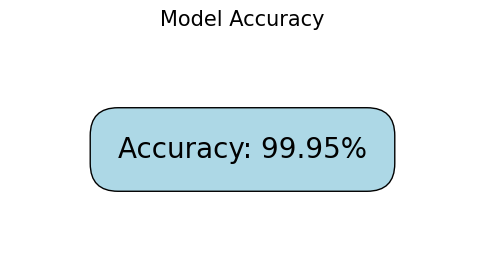

In [67]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Display the accuracy score in a styled manner
plt.figure(figsize=(6, 3))
plt.text(0.5, 0.5, f'Accuracy: {accuracy*100:.2f}%', fontsize=20, ha='center', va='center',
         bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=1'))
plt.axis('off')
plt.title("Model Accuracy", fontsize=15)
plt.show()


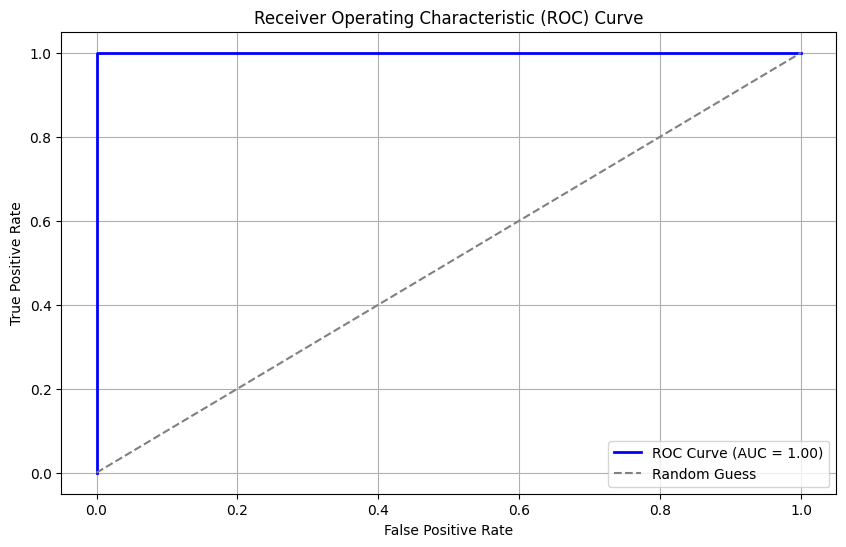

In [68]:
from sklearn.metrics import roc_curve, auc

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

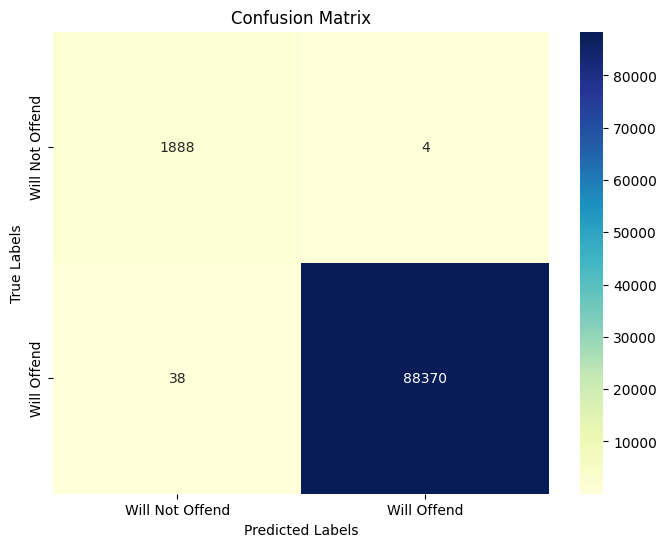

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create labels for the heatmap
labels = ['Will Not Offend', 'Will Offend']

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


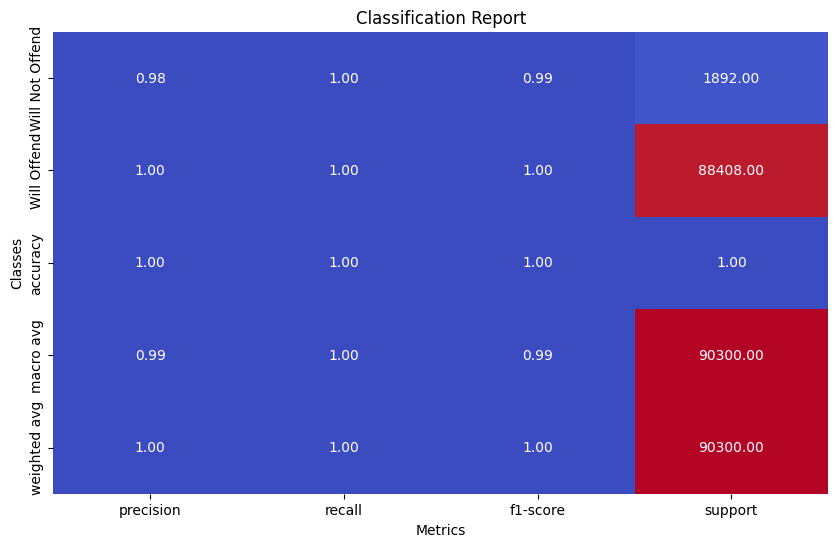

In [70]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=['Will Not Offend', 'Will Offend'], output_dict=True)

# Convert the report into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Highlight metrics in the classification report using heatmap (including support)
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


In [71]:
!git add .
!git commit -m "With ROC analysis"
!git push origin main


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
